In [41]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime

from sklearn.preprocessing import StandardScaler, FunctionTransformer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
plt.style.use('seaborn-whitegrid')
%matplotlib inline

C:\Users\adity\AppData\Local\Temp\ipykernel_18280\3882865177.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [42]:
DATA_DIR = 'Data/'

In [43]:
## Read data
FILE = DATA_DIR + 'multivariate_timeseries_data.csv'
df = pd.read_csv(FILE, sep = ",", header = 0)

pd.to_datetime: This function is used to convert argument to datetime.

In [44]:
df['time'] = pd.to_datetime(df['time'], format='%m-%d-%Y %H.%M')
df = df.set_index('time')
df.loc[:, df.columns != 'time'] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
s = df.select_dtypes(include = 'object').columns
df[s] = df[s].astype('float')
df.dtypes

Cyclone_Inlet_Gas_Temp      float64
Cyclone_Material_Temp       float64
Cyclone_Outlet_Gas_draft    float64
Cyclone_cone_draft          float64
Cyclone_Gas_Outlet_Temp     float64
Cyclone_Inlet_Draft         float64
dtype: object

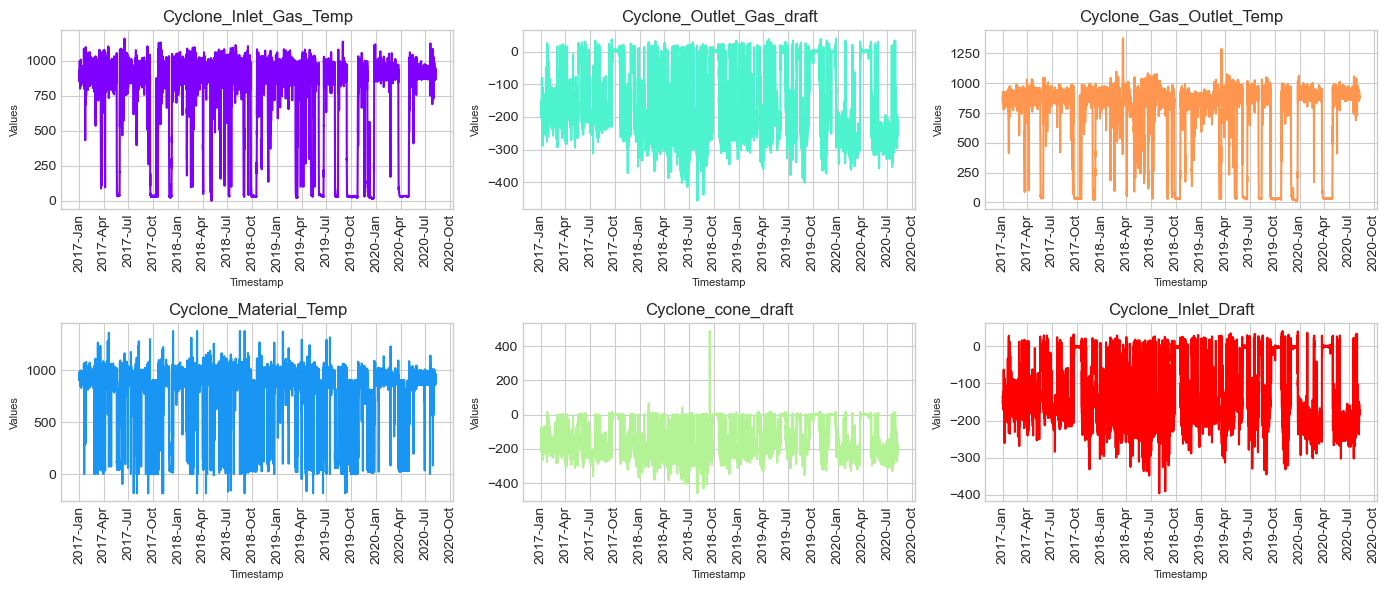

In [45]:
## Plot timeseries data
colors = cm.rainbow(np.linspace(0, 1, 6))
fig, ax = plt.subplots(2, 3, figsize = (14, 6), tight_layout = True)
for i in range(2):
  for j in range(3):
    col = df.columns[i+2*j]
    ax[i,j].plot(df.index[df[col].notna()], df[col][df[col].notna()], color = colors[i+2*j])
    ax[i, j].set_xlabel('Timestamp', fontsize = 8)
    ax[i, j].set_ylabel('Values', fontsize = 8)
    ax[i, j].set_title(col, fontsize = 12)
    ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1, 12, 3)))
    ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax[i, j].tick_params(axis = 'x', rotation = 90);

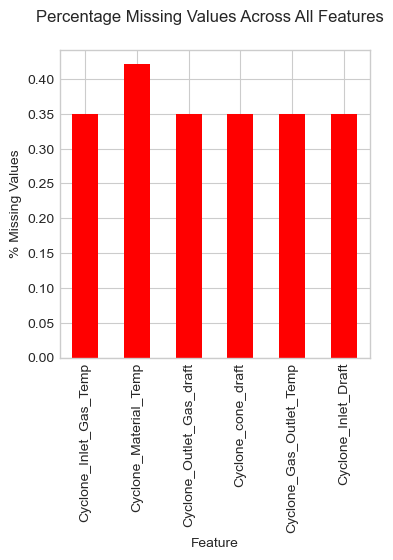

In [46]:
## Plot percentage of missing values (NaNs) for each feature
fig = plt.figure(figsize=(4, 4))
fig.tight_layout()
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= 1).values.astype(int)])
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 12)
plt.xlabel('Feature', fontsize = 10)
plt.ylabel('% Missing Values', fontsize = 10);

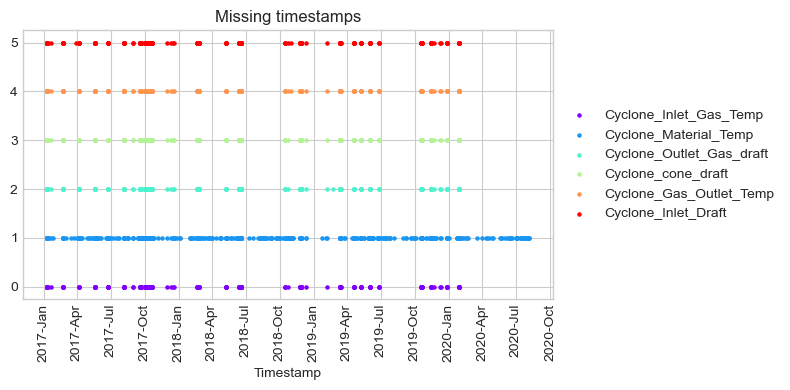

In [47]:
## Get timestamps of missing values for each column
## and plot them
fig, ax = plt.subplots(1, 1, figsize = (8, 4), tight_layout = True)
for j, col in enumerate(df.columns):
  # Get missing timestamps for this column
  missing_value_timestamps = df.index[df[col].isna()]
  # Plot missing timestamps for this column
  ax.scatter(missing_value_timestamps, [0+j] * len(missing_value_timestamps),
              color = colors[j],
              s = 5,
              label = col)

ax.set_title('Missing timestamps', fontsize = 12)
ax.set_xlabel('Timestamp', fontsize = 10)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1, 12, 3)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.tick_params(axis = 'x', rotation = 90);

In [60]:
## Linear interpolation for missing values
#df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].interpolate(method = 'linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

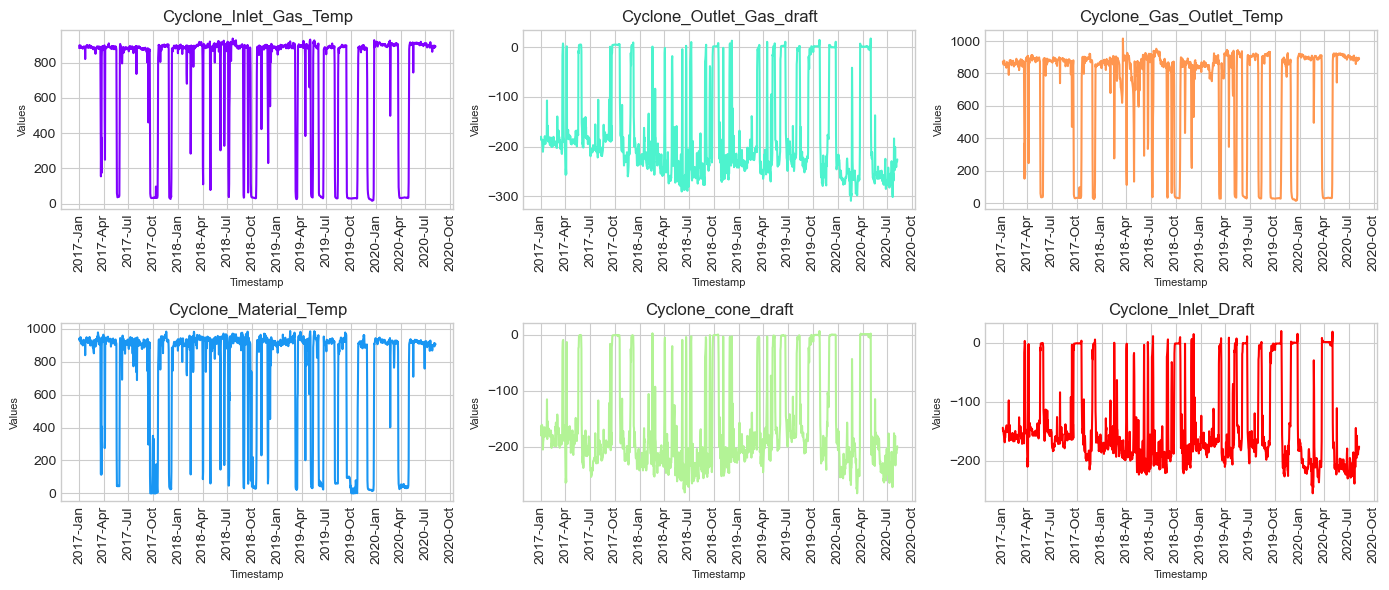

In [61]:
## Downsample to daily frequency and plot timeseries data
df_daily = df.resample('D').mean()
fig, ax = plt.subplots(2, 3, figsize = (14, 6), tight_layout = True)
for i in range(2):
  for j in range(3):
    col = df_daily.columns[i+2*j]
    ax[i,j].plot(df_daily.index[df_daily[col].notna()], df_daily[col][df[col].notna()], color = colors[i+2*j])
    ax[i, j].set_xlabel('Timestamp', fontsize = 8)
    ax[i, j].set_ylabel('Values', fontsize = 8)
    ax[i, j].set_title(col, fontsize = 12)
    ax[i, j].xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1, 12, 3)))
    ax[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax[i, j].tick_params(axis = 'x', rotation = 90);

pd.Timedelta: Represents a duration, the difference between two dates or times.

pd.date_range: Returns a fixed frequency DatetimeIndex.

np.concatenate: Join a sequence of arrays along an existing axis.

df.index: The index (row labels) of the DataFrame.

df.resample: Convenience method for frequency conversion and resampling of time series.

df.fit_transform: This is a method from scikit-learn's transformers, used to fit the data and then transform it.

pd.DateOffset: Represents a duration of time.

In [62]:
## Data preparation for anomaly detection using numpy
# Note that 5min is the sampling period in the dataset which
# we specify and convert to seconds
sampling_period = int(pd.Timedelta('5min').total_seconds())
# We are interested in 30min data for each sample which
# we specify and convert to seconds
time_period = int(pd.Timedelta('30min').total_seconds())
# The following is a dictionary that we will use for transforming the columns
# 'identity' corresponds to no transformation, 'standard' means standardizing
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['standard'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed.index = df.index.copy()
ncols_reshape = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
nrows_reshape = df_transformed.shape[0]//ncols_reshape
df_samples = pd.DataFrame(np.concatenate([np.array(df_transformed[feature])[0:nrows_reshape*ncols_reshape].reshape(nrows_reshape, ncols_reshape) for feature in df_transformed.columns.values], axis = 1))
df_samples.index = pd.date_range(df_transformed.index.min(),
                                 df_transformed.index.max() + pd.DateOffset(days = 1),
                                 normalize = True,
                                 freq = str(time_period)+'S')[0:df_samples.shape[0]]
df_samples.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2017-01-01 00:00:00,0.429433,0.464612,0.453816,0.452633,0.502307,0.462519,0.457338,0.479265,0.496420,0.493495,...,0.464489,0.463846,0.495128,0.477510,-0.062775,-0.112398,-0.051333,-0.023179,-0.030507,-0.075887
2017-01-01 00:30:00,0.545613,0.460366,0.439684,0.544157,0.452117,0.531238,0.573506,0.540303,0.537747,0.538684,...,0.480697,0.480697,0.502940,0.508762,-0.139009,-0.111626,-0.059175,-0.101085,-0.040920,-0.010580
2017-01-01 01:00:00,0.450298,0.474316,0.436924,0.522959,0.408417,0.499820,0.506731,0.536156,0.499687,0.553567,...,0.459005,0.510539,0.448281,0.490103,-0.109955,-0.031149,-0.072802,0.006004,0.021688,-0.117540
2017-01-01 01:30:00,0.412936,0.440836,0.502550,0.430555,0.428827,0.433861,0.491450,0.482077,0.520790,0.491052,...,0.496966,0.471505,0.464489,0.460598,-0.037449,-0.065603,-0.039763,-0.038092,-0.023436,0.008832
2017-01-01 02:00:00,0.468827,0.495363,0.438895,0.441139,0.447265,0.455574,0.518149,0.541553,0.536810,0.514258,...,0.498559,0.488908,0.495587,0.484128,0.062955,0.028758,-0.078330,-0.002481,-0.052490,-0.056475


In [66]:
   
## Anomaly detection using numpy
# Calculate the mean and standard deviation for each feature
mean = df_samples.mean()
std = df_samples.std()
# Calculate the z-score for each feature
z = ((df_samples - mean) / std).abs()
# Calculate the z-score threshold for anomaly detection
threshold = 3
# Detect anomalies
anomalies = z > threshold

## print anomalies
print(anomalies.sum())



0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    2
21    0
22    1
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    1
33    0
34    1
35    0
dtype: int64
